In [ ]:
import datetime as dt
import json
import math
import os
import sys
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from ethnicolr2 import *
from PIL import Image
from plotly.subplots import make_subplots
from scipy import stats

sys.path.append("/Users/clintswift/projects/cstools")
from csfunctions import *

In [ ]:
# Stuff to make plots and stuff
def Sort_Tuple(tup):
    return sorted(tup, key=lambda x: x[1])


# creates coordinates for the locations of the dots in the par charts.
def parlamentary_Coord(df, angle_total=180, rows=4, ratio=6, initial="name"):
    arco_total = 0
    angles = []
    for i in range(rows):
        arco_total += math.pi * int(ratio + i)
    for i in range(rows):
        arco_radio = math.pi * int(ratio + i)
        angles.append(angle_total / round(arco_radio / (arco_total / len(df)), 0))
    coord = []
    for a in range(len(angles)):
        current_angle = angles[a] / 2
        for i in range(int(round(angle_total / angles[a], 0))):
            coord.append((ratio + a, current_angle))
            current_angle += angles[a]

    coord = Sort_Tuple(coord)

    df["radio"] = list(zip(*coord))[0]
    df["tetha"] = list(zip(*coord))[1]
    df["INITIAL"] = df[initial].apply(lambda x: x[0])  # only for text in marker chart
    return df


# this will format the data for the parlimentary charts
def par_data(df_seats, s="no_change", t="MMP", p=4):
    seats = (
        df_seats[
            (df_seats["scenario"] == s)
            & (df_seats["type"] == t)
            & (df_seats["parties"] == p)
        ][[x for x in df_seats.columns if "mean" in x]]
        .values.astype(int)
        .flatten()
        .tolist()
    )
    d_ = pd.DataFrame(
        seats[3] * [["M", "MAGA", pd_colors("red")]]
        + seats[2] * [["R", "Rep.", pd_colors("red", 0.2)]]
        + seats[1] * [["D", "Dem.", pd_colors("navy", 0.2)]]
        + seats[0] * [["P", "Prog.", pd_colors("navy")]]
    )
    # d_["s"] = t + " - " + (s.replace("_", " ").title())
    d_["s"] = t
    d_.columns = ["name", "party", "color", "s"]
    return d_


# implement the par charts
def par_graph(
    df,
    graph_style="none",
    height=500,
    angle_total=120,
    size_marker=25,
    leg=True,
    anno=True,
):
    df = parlamentary_Coord(df, angle_total, 6, 4)

    angle_start = (180 - angle_total) / 2
    angle_end = 180 + (angle_total - 180) / 2

    d_ict = df[["party", "color"]]
    d_ict = d_ict.drop_duplicates()
    dct = dict(d_ict.values)
    fig = px.scatter_polar(
        df,
        r="radio",
        theta="tetha",
        color="party",
        color_discrete_map=dct,
        start_angle=angle_start,
        custom_data=["name"],
        range_theta=[angle_start, angle_end],
        direction="counterclockwise",
    )
    fig.update_layout(
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        margin=dict(b=5, r=5, l=5, t=30),
        height=height,
        width=850,
        polar=dict(
            radialaxis=dict(
                showticklabels=False, ticks="", linecolor="rgba(255, 255, 255, 0)"
            ),
            angularaxis=dict(showticklabels=False, ticks="", linecolor="rgba(0,0,0,0)"),
            bgcolor=pd_colors("cream", 0),
        ),
        polar_radialaxis_gridcolor="rgba(0,0,0,0)",
        polar_angularaxis_gridcolor="rgba(0,0,0,0)",
    )
    fig.update_traces(textposition="middle center")
    fig.update_traces(
        hovertemplate="<b>%{customdata[0]}</b><extra></extra>",
        textfont_size=12,
    )
    fig.update_layout(
        template=graph_style,
        autosize=True,
        showlegend=leg,
        legend=dict(
            title="Party",
            traceorder="normal",
            y=0.05,
            x=0.80,
            bgcolor=pd_colors("cream", 0),
            bordercolor=pd_colors("lead"),
            borderwidth=1,
            itemwidth=30,
            entrywidth=35,
        ),
        uniformtext_minsize=8,
        uniformtext_mode="hide",
        font=dict(family="Arial, monospace", size=12),
        paper_bgcolor=pd_colors("cream", 0),
        plot_bgcolor=pd_colors("cream", 0),
        # margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.update_traces(marker=dict(opacity=1, size=size_marker))

    if anno == True:
        fig.add_annotation(
            x=0.5,
            y=0.075,
            text=df[:1]["s"].values[0],
            showarrow=False,
            font=dict(color="black", size=35),
        )

    return fig


# supplementary bars for under the pars
def party_bar(df, s="no_change", t="MMP", p=4):
    bar_df = df[(df["scenario"] == s) & (df["type"] == t) & (df["parties"] == p)].copy()
    col = [
        pd_colors("red"),
        pd_colors("red", 0.2),
        pd_colors("navy", 0.2),
        pd_colors("navy"),
    ]
    c = 0
    fig = go.Figure()
    for p in ["m", "r", "d", "p"]:
        fig.add_trace(
            go.Bar(
                name=p,
                x=[bar_df[p + "_mean"].values[0]],
                y=[c],
                error_x=dict(
                    type="data",
                    array=[bar_df[p + "_sem"].values[0]],
                    color="grey",
                    thickness=2,
                    width=3,
                ),
                orientation="h",
                marker_color=col[c],
            )
        )
        c = c + 1
    fig.update_layout(
        yaxis_title_text="",
        xaxis_title_text="Expected Seats (%)",
        # template="plotly_white",
        autosize=False,
        showlegend=False,
        font=dict(color="black", size=16),
        width=850,
        height=100,
        margin=dict(l=50, r=50, t=10, b=40),
        xaxis_range=[-5, 62],
        xaxis_gridcolor=pd_colors("lead", 0.3),
        xaxis=dict(
            tickmode="array",
            tickvals=[0, 10, 20, 30, 40, 50, 60],
        ),
        yaxis=dict(visible=False),
        paper_bgcolor=pd_colors("cream", 0),
        plot_bgcolor=pd_colors("cream", 0),
    )
    return fig


# For some reason the polar scatter in plotly cannot be put into a subplot so combining with this
from PIL import Image


def combine_images_vertically(image_path1, image_path2, output_path, crop1=False):
    try:
        img1 = Image.open(image_path1)
        img2 = Image.open(image_path2)
    except FileNotFoundError:
        print("Error: One or both image files not found.")
        return
    except Exception as e:
        print(f"Error opening images: {e}")
        return

    # same width?
    if img1.width != img2.width:
        # Resize the wider image to match the narrower one's width
        min_width = min(img1.width, img2.width)
        img1 = img1.resize((min_width, int(img1.height * min_width / img1.width)))
        img2 = img2.resize((min_width, int(img2.height * min_width / img2.width)))

    if crop1 == True:
        bbox = img1.getbbox()
        img1 = img1.crop(bbox)

    total_height = img1.height + img2.height
    combined_image = Image.new("RGBA", (img1.width, total_height))

    combined_image.paste(img1, (0, 0))
    combined_image.paste(img2, (0, img1.height))

    im2 = combined_image.copy()
    im2.putalpha(255)
    combined_image.paste(im2, combined_image)

    bbox = combined_image.getbbox()
    combined_image = combined_image.crop(bbox)

    try:
        combined_image.save(output_path)
        print(f"Images combined and saved to {output_path}")
    except Exception as e:
        print(f"Error saving combined image: {e}")

In [ ]:
# never enxcountered a pickle before so prob better way to do this...
df_ = pd.DataFrame([])
for t in ["MMP", "OL9", "OL5"]:
    for s in ["no_change", "more_gop", "more_dem"]:
        for p in [2, 4]:
            d_ = pd.DataFrame(
                pd.read_pickle("raw_data/saved_legislatures_updated_fit.pkl")[t][s][p]
            )
            d_["type"] = t
            d_["scenario"] = s
            d_["parties"] = p

            df_ = pd.concat([df_, d_], axis=0)

df_ = df_[["type", "scenario", "parties", "D", "R", "P", "M"]]

In [ ]:
df__ = pd.DataFrame([])
scen = ["no_change", "more_dem", "more_gop"]
for sc in ["no_change", "more_dem", "more_gop"]:
    d = pd.DataFrame(pd.read_pickle(f"raw_data/smd_1000_{sc}.pkl"))
    d["type"] = "WTA"
    d["scenario"] = sc
    d["parties"] = 4

    df__ = pd.concat([df__, d], axis=0)
df_ = pd.concat([df_, df__], axis=0)

# add current
df_ = pd.concat(
    [
        df_,
        pd.DataFrame(
            {
                "type": ["WTA"],
                "scenario": ["current"],
                "D": [71],
                "R": [77],
                "P": [0],
                "M": [0],
                "parties": [2],
            }
        ),
    ],
    axis=0,
)

In [ ]:
df = (
    df_.groupby(["type", "scenario", "parties"])
    .agg(
        {
            "P": ["mean", "std"],
            "D": ["mean", "std"],
            "R": ["mean", "std"],
            "M": ["mean", "std"],
        }
    )
    .reset_index()
)

c = []
for x, y in df.columns.tolist():
    if y == "":
        z = ""
    else:
        z = "_"

    c_ = [(x + z + y).lower()]
    c = c_ + c

df.columns = list(reversed(c))

# Show 95% of results in bands
for c in [
    "p",
    "d",
    "r",
    "m",
]:
    df[c + "_sem"] = 1.96 * (df[c + "_std"])
    df[c + "_hi"] = df[c + "_mean"] + df[c + "_sem"]
    df[c + "_lo"] = df[c + "_mean"] - df[c + "_sem"]

In [ ]:
# Round the means to get number of seats
df_seats = pd.concat(
    [df[df.columns[:3]], round(df[[x for x in df.columns if "mean" in x]])], axis=1
)
df_seats = df_seats.fillna(0)

In [ ]:
# edge case rounding issues manual fix (make the total seats work)
df_seats.loc[
    (df_seats["scenario"] == "no_change")
    & (df_seats["type"] == "OL5")
    & (df_seats["parties"] == 4),
    "p_mean",
] = 8
df_seats.loc[
    (df_seats["scenario"] == "more_dem")
    & (df_seats["type"] == "OL5")
    & (df_seats["parties"] == 4),
    "m_mean",
] = 6
df_seats.loc[
    (df_seats["scenario"] == "more_gop")
    & (df_seats["type"] == "MMP")
    & (df_seats["parties"] == 4),
    "d_mean",
] = 51
df_seats.loc[
    (df_seats["scenario"] == "more_dem")
    & (df_seats["type"] == "MMP")
    & (df_seats["parties"] == 4),
    "p_mean",
] = 13

In [ ]:
# create the data for the bars
df["tot"] = df[[x for x in df.columns if "mean" in x]].sum(axis=1)
df_bar = df.copy()
for p in ["m", "r", "d", "p"]:
    df_bar[p + "_mean"] = 100 * (df_bar[p + "_mean"] / df_bar["tot"])

In [ ]:
# Make the full figures
for p in [2, 4]:
    for t in df["type"].unique().tolist():
        for s in scen:
            if (p == 2) & (t == "WTA"):
                continue

            fig_name = f"{t}_{s}_{str(p)}"
            # print(fig_name)
            par_graph(
                par_data(df_seats, s=s, t=t, p=p),
                height=500,
                angle_total=130,
                size_marker=25,
            ).write_image(f"figures/{fig_name}_a.png")
            party_bar(df=df_bar, t=t, s=s, p=p).write_image(f"figures/{fig_name}_b.png")

            combine_images_vertically(
                f"figures/{fig_name}_a.png",
                f"figures/{fig_name}_b.png",
                f"figures/{fig_name}.png",
                crop1=True,
            )
            os.remove(f"figures/{fig_name}_a.png")
            os.remove(f"figures/{fig_name}_b.png")

In [ ]:
# Make the compact figures
for p in [2, 4]:
    for t in df["type"].unique().tolist():
        for s in scen:
            if (p == 2) & (t == "WTA"):
                continue
            fig_name = f"{t}_{s}_{str(p)}"
            par_graph(
                par_data(df_seats, s=s, t=t, p=p),
                height=500,
                angle_total=130,
                size_marker=25,
                leg=False,
                anno=False,
            ).write_image(f"figures/{fig_name}_a.png")
            party_bar(df=df_bar, t=t, s=s, p=p).write_image(f"figures/{fig_name}_b.png")

            combine_images_vertically(
                f"figures/{fig_name}_a.png",
                f"figures/{fig_name}_b.png",
                f"figures/{fig_name}_nl.png",
                crop1=True,
            )
            os.remove(f"figures/{fig_name}_a.png")
            # os.remove(f"figures/{fig_name}_b.png")

In [ ]:
# A legend to use for the party stuff when needed.
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=[0],
        y=[0],
        name="MAGA",
        mode="markers",
        marker_color=pd_colors("red"),
        marker_size=25,
    )
)
fig.add_trace(
    go.Scatter(
        x=[0],
        y=[0],
        name="Rep.",
        mode="markers",
        marker_color=pd_colors("red", 0.2),
        marker_size=25,
    )
)
fig.add_trace(
    go.Scatter(
        x=[0],
        y=[0],
        name="Dem.",
        mode="markers",
        marker_color=pd_colors("navy", 0.2),
        marker_size=25,
    )
)
fig.add_trace(
    go.Scatter(
        x=[0],
        y=[0],
        name="Prog.",
        mode="markers",
        marker_color=pd_colors("navy"),
        marker_size=25,
    )
)
fig.update_layout(
    # title = "Michigan Voter Records with 'Citizenship' Related Status Reasons",
    xaxis_title_text="% MAGA",
    yaxis_title_text="% Prog.",
    template="plotly_white",
    legend=dict(
        title="Party",
        traceorder="normal",
        y=0.95,
        x=0.8,
        bgcolor=pd_colors("dark cream", 0.0),
        # bordercolor=pd_colors("lead"),
        # borderwidth=1,
        # itemwidth=30,
        # entrywidth=35,
    ),
    autosize=False,
    font=dict(color="black", size=16),
    width=120,
    height=200,
    margin=dict(l=30, r=30, t=30, b=30),
    xaxis_gridcolor=pd_colors("lead", 0),
    yaxis_gridcolor=pd_colors("lead", 0),
    yaxis_range=[3, 15],
    xaxis_range=[3, 15],
    xaxis_visible=False,
    yaxis_visible=False,
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
fig.write_image(f"figures/party_legend.png")

In [ ]:
df_4 = df_[(df_["parties"] == 4) & (df_["scenario"] == "no_change")].copy()
df_4["tot"] = df_4[["D", "R", "P", "M"]].sum(axis=1)
for p in ["D", "R", "P", "M"]:
    df_4[p] = 100 * (df_4[p] / (df_4["tot"]))

In [ ]:
df_4["dmaj"] = np.where(df_4["D"] > 50, True, False)
df_4["rmaj"] = np.where(df_4["R"] > 50, True, False)
df_4["pmaj"] = np.where((df_4["D"] + df_4["P"]) > 50, True, False)
df_4["mmaj"] = np.where((df_4["R"] + df_4["M"]) > 50, True, False)
print(
    "Majorities w/ just the major parties (D & R) or the major inclusing their extremist wing (P&M)"
)
df_4.groupby("type").agg(
    {"dmaj": "sum", "rmaj": "sum", "pmaj": "sum", "mmaj": "sum"}
).reset_index()

In [ ]:
# Maga seats by system
df_vio = df_.copy()
df_vio["tot"] = df_vio[["D", "R", "P", "M"]].sum(axis=1)
df_vio["M"] = 100 * (df_vio["M"] / df_vio["tot"])
df_vio["P"] = 100 * (df_vio["P"] / df_vio["tot"])
df_vio["E"] = df_vio["P"] + df_vio["M"]

y = "M"
t_ = ["MMP", "OL5", "OL9"]

if y == "P":
    color = "navy"
    l = "Progessive"
if y == "E":
    color = "vs purple"
    l = "Extreme"
else:
    color = "red"
    l = "MAGA"

# Order
df_vio["o"] = df_vio["type"].map({"MMP": 1, "OL5": 2, "OL9": 3, "WTA": 0})

fig = go.Figure()
for t in t_:
    # Commented out traces provide lines for the more gop/ more dem scenarios.
    # fig.add_trace(
    #     go.Violin(
    #         y=df_vio[
    #             (df_vio["scenario"] == "more_gop")
    #             & (df_vio["parties"] == 4)
    #             & (df_vio["type"] == t)
    #         ]["o"],
    #         x=df_vio[
    #             (df_vio["scenario"] == "more_gop")
    #             & (df_vio["parties"] == 4)
    #             & (df_vio["type"] == t)
    #         ]["M"],
    #         name="Rep. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("red", 0.6),
    #     )
    # )
    # fig.add_trace(
    #     go.Violin(
    #         y=df_vio[
    #             (df_vio["scenario"] == "more_dem")
    #             & (df_vio["parties"] == 4)
    #             & (df_vio["type"] == t)
    #         ]["o"],
    #         x=df_vio[
    #             (df_vio["scenario"] == "more_dem")
    #             & (df_vio["parties"] == 4)
    #             & (df_vio["type"] == t)
    #         ]["M"],
    #         name="Dem. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("navy", 0.6),
    #     )
    # )
    fig.add_trace(
        go.Violin(
            y=df_vio[
                (df_vio["scenario"] == "no_change")
                & (df_vio["parties"] == 4)
                & (df_vio["type"] == t)
            ]["o"],
            x=df_vio[
                (df_vio["scenario"] == "no_change")
                & (df_vio["parties"] == 4)
                & (df_vio["type"] == t)
            ][y],
            name="No Change",
            box_visible=False,
            meanline_visible=True,
            points="outliers",
            fillcolor=pd_colors(color, 0.2),
            line_color=pd_colors(color),
        )
    )

fig.add_trace(
    go.Violin(
        y=df_vio[
            (df_vio["scenario"] == "no_change")
            & (df_vio["parties"] == 4)
            & (df_vio["type"] == "WTA")
        ]["o"],
        x=df_vio[
            (df_vio["scenario"] == "no_change")
            & (df_vio["parties"] == 4)
            & (df_vio["type"] == "WTA")
        ][y],
        name="No Change",
        box_visible=False,
        meanline_visible=True,
        points="outliers",
        fillcolor=pd_colors(color, 0.2),
        line_color=pd_colors(color),
    )
)
fig.update_layout(
    yaxis_title_text="",
    xaxis_title_text=f"{l} Seats (%)",
    template="plotly_white",
    autosize=False,
    showlegend=False,
    font=dict(color="black", size=18),
    width=950,
    height=625,
    margin=dict(l=20, r=20, t=10, b=10),
    xaxis_zeroline=False,
    xaxis_gridcolor=pd_colors("lead", 0.2),
    yaxis=dict(
        tickmode="array",
        tickvals=[0.3, 1.3, 2.3, 3.3],
        ticktext=["WTA", "MMP", "OL5", "OL9"],
    ),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
# fig.update_traces(meanline_visible=True, box_visible=False)
fig.update_traces(
    orientation="h",
    side="positive",
    width=1.8,
)
fig.show()
fig.write_image(f"figures/{y}_seats.png")

In [ ]:
t_ = ["WTA", "MMP", "OL5", "OL9"]
for t in t_:
    v = df_vio[df_vio["type"] == t]["M"].std()
    mm = df_vio[df_vio["type"] == t]["M"].max() - df_vio[df_vio["type"] == t]["M"].min()
    print(f"{t}: sd = {v:.3f}, range = {mm:.3f}")

In [ ]:
df_sc = df_[(df_["parties"] == 4) & (df_["scenario"] == "no_change")].copy()
df_scm = df[(df["parties"] == 4) & (df["scenario"] == "no_change")].copy()

for c in ["M", "P", "R", "D"]:
    df_sc[c.lower() + "_per"] = 100 * (
        df_sc[c] / (df_sc["D"] + df_sc["P"] + df_sc["R"] + df_sc["M"])
    )
    df_scm[c.lower() + "_per"] = 100 * (
        df_scm[c.lower() + "_mean"]
        / (df_scm["d_mean"] + df_scm["p_mean"] + df_scm["r_mean"] + df_scm["m_mean"])
    )

In [ ]:
df_sc["ext_per"] = df_sc["m_per"] + df_sc["p_per"]
df_sc["int_per"] = df_sc["d_per"] + df_sc["r_per"]

In [ ]:
jitter_amount = 0.8

df_sc["p_jit"] = df_sc["p_per"] + np.random.uniform(
    -jitter_amount, jitter_amount, len(df_sc)
)
df_sc["m_jit"] = df_sc["m_per"] + np.random.uniform(
    -jitter_amount, jitter_amount, len(df_sc)
)
df_sc["p_jit"] = np.where(df_sc["p_jit"] < 0.00001, 0.00001, df_sc["p_jit"])
df_sc["m_jit"] = np.where(df_sc["m_jit"] < 0.00001, 0.00001, df_sc["m_jit"])

df_sc["r_jit"] = df_sc["r_per"] + np.random.uniform(
    -jitter_amount, jitter_amount, len(df_sc)
)
df_sc["d_jit"] = df_sc["d_per"] + np.random.uniform(
    -jitter_amount, jitter_amount, len(df_sc)
)
df_sc["r_jit"] = np.where(df_sc["r_jit"] < 0.00001, 0.00001, df_sc["r_jit"])
df_sc["d_jit"] = np.where(df_sc["d_jit"] < 0.00001, 0.00001, df_sc["d_jit"])

In [ ]:
R = []
from scipy.stats import pearsonr

for t in t_ + ["WTA"]:
    r, p = pearsonr(
        df_sc[df_sc["type"] == t]["p_per"], df_sc[df_sc["type"] == t]["m_per"]
    )
    x = [t, f"R &#61; {r:.3f} (p &#61; {p:.3f})".replace("0.000", "<0.000")]
    print(x)
    R = R + [x]

In [ ]:
col = [
    pd_colors("vs purple", 0.4),
    pd_colors("vs orange", 0.4),
    pd_colors("vs green", 0.4),
    pd_colors("red", 0.4),
]

fig = px.scatter(
    df_sc,
    x="m_jit",
    y="p_jit",
    facet_col="type",
    facet_col_wrap=2,
    color="type",
    color_discrete_sequence=list(reversed(col)),
    trendline="ols",
    trendline_options=dict(log_y=True),
    category_orders={"type": ["WTA", "MMP", "OL5", "OL9"]},
)

# bottom right
fig.add_annotation(
    x=0.75,
    xref="paper",
    xanchor="center",
    y=0.44,
    yref="paper",
    yanchor="middle",
    text=f"{R[2][1]}",
    showarrow=False,
)
#
fig.add_annotation(
    x=0.25,
    xref="paper",
    xanchor="center",
    y=0.44,
    yref="paper",
    yanchor="middle",
    text=f"{R[1][1]}",
    showarrow=False,
)

fig.add_annotation(
    x=0.75,
    xref="paper",
    xanchor="center",
    y=0.98,
    yref="paper",
    yanchor="middle",
    text=f"{R[0][1]}",
    showarrow=False,
)

fig.add_annotation(
    x=0.25,
    xref="paper",
    xanchor="center",
    y=0.98,
    yref="paper",
    yanchor="middle",
    text=f"{R[3][1]}",
    showarrow=False,
)

fig.add_annotation(
    x=-0.04,
    xref="paper",
    xanchor="center",
    y=0.5,
    yref="paper",
    yanchor="middle",
    text="% Progressive",
    font_size=20,
    textangle=-90,
    showarrow=False,
)
fig.add_annotation(
    x=0.5,
    xref="paper",
    xanchor="center",
    y=-0.05,
    yref="paper",
    yanchor="middle",
    text="% MAGA",
    font_size=20,
    textangle=0,
    showarrow=False,
)

fig.update_traces(
    marker={
        "size": 4,
    },
    line={
        "color": pd_colors("lead", 0.6),
        "width": 3,
    },
)
fig.update_xaxes(
    title="",
    showgrid=False,
    zeroline=False,
    showticklabels=True,
    showline=True,
    matches=None,
    ticks="",
    linewidth=1,
    linecolor="black",
    tickfont=dict(size=10),
)
fig.update_yaxes(
    title="",
    showgrid=False,
    zeroline=False,
    showticklabels=True,
    showline=True,
    matches=None,
    ticks="",
    linewidth=1,
    linecolor="black",
    tickfont=dict(size=10),
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(
    # title = "Michigan Voter Records with 'Citizenship' Related Status Reasons",
    showlegend=False,
    template="plotly_white",
    autosize=False,
    font=dict(color="black", size=16),
    width=800,
    height=600,
    margin=dict(l=40, r=10, t=25, b=40),
    # yaxis_range=[0, 15],
    # xaxis_range=[0, 15],
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
fig.show()
fig.write_image("figures/p_m_scatter.png")

In [ ]:
col = [
    pd_colors("vs purple", 0.4),
    pd_colors("vs orange", 0.4),
    pd_colors("vs green", 0.4),
    pd_colors("red", 0.4),
]

fig = px.scatter(
    df_sc,
    x="r_jit",
    y="m_jit",
    facet_col="type",
    facet_col_wrap=2,
    color="type",
    color_discrete_sequence=list(reversed(col)),
    trendline="ols",
    trendline_options=dict(log_x=True, log_y=True),
    category_orders={"type": ["WTA", "MMP", "OL5", "OL9"]},
)

fig.add_annotation(
    x=0.5,
    xref="paper",
    xanchor="center",
    y=-0.05,
    yref="paper",
    yanchor="middle",
    text="% Republicans",
    font_size=20,
    textangle=0,
    showarrow=False,
)
fig.add_annotation(
    x=-0.04,
    xref="paper",
    xanchor="center",
    y=0.5,
    yref="paper",
    yanchor="middle",
    text="% MAGA",
    font_size=20,
    textangle=-90,
    showarrow=False,
)

fig.update_traces(
    marker={
        "size": 4,
    },
    line={
        "color": pd_colors("lead", 0.6),
        "width": 3,
    },
)
fig.update_xaxes(
    title="",
    showgrid=False,
    zeroline=False,
    showticklabels=True,
    showline=True,
    matches=None,
    ticks="",
    linewidth=1,
    linecolor="black",
    tickfont=dict(size=10),
    range=[25, 65],
)
fig.update_yaxes(
    title="",
    showgrid=False,
    zeroline=False,
    showticklabels=True,
    showline=True,
    matches=None,
    ticks="",
    linewidth=1,
    linecolor="black",
    tickfont=dict(size=10),
    range=[0, 20],
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(
    # title = "Michigan Voter Records with 'Citizenship' Related Status Reasons",
    showlegend=False,
    template="plotly_white",
    autosize=False,
    font=dict(color="black", size=16),
    width=800,
    height=600,
    margin=dict(l=40, r=10, t=25, b=40),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
fig.show()
fig.write_image("figures/m_r_scatter.png")

In [ ]:
df_p = df_[
    (df_["scenario"].isin(["no_change", "current"])) & (df_["parties"] == 2)
].copy()

df_p["r_per"] = 100 * (df_p["R"] / df_p[["D", "R"]].sum(axis=1))
df_p["d_per"] = 100 * (df_p["D"] / df_p[["D", "R"]].sum(axis=1))
df_p["r_adv"] = df_p["r_per"] - df_p["d_per"]

x = df_p.loc[(df_p["scenario"] == "current") & (df_p["type"] == "WTA")]["R"].values[0]
y = (
    x
    + df_p.loc[(df_p["scenario"] == "current") & (df_p["type"] == "WTA")]["D"].values[0]
)
z = df_p.loc[(df_p["scenario"] == "current") & (df_p["type"] == "WTA")]["d_per"].values[
    0
]
t = 100 * ((x - 1) / y)
current = t - z
df_p = df_p[(df_p["scenario"] == "no_change")].copy()

In [ ]:
df_p = df_[(df_["parties"] == 2)].copy()
df_p["r_per"] = 100 * (df_p["R"] / df_p[["D", "R"]].sum(axis=1))
df_p["d_per"] = 100 * (df_p["D"] / df_p[["D", "R"]].sum(axis=1))
df_p["r_adv"] = df_p["r_per"] - df_p["d_per"]
df_p["r_adv_seats"] = df_p["R"] - df_p["D"]

t_ = ["MMP", "OL5", "OL9"]
c = "blue"
# Order
df_p["o"] = df_p["type"].map(
    {
        "MMP": 1,
        "OL5": 2,
        "OL9": 3,
    }
)


fig = go.Figure()
for t in t_:
    fig.add_trace(
        go.Violin(
            y=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == t)]["o"],
            x=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == t)]["r_adv"],
            name="No Change",
            box_visible=False,
            meanline_visible=True,
            points="outliers",
            fillcolor=pd_colors(c, 0.4),
            line_color=pd_colors(c, 0),
        )
    )
    # fig.add_vline(x=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == t)]["r_adv"].mean(), line_color=pd_colors("blue"), line_width=3, line_dash="dash")
    # fig.add_trace(
    #     go.Violin(
    #         y=df_p[(df_p["scenario"] == "more_dem") & (df_p["type"] == t)]["o"],
    #         x=df_p[(df_p["scenario"] == "more_dem") & (df_p["type"] == t)]["r_adv"],
    #         name="Dem. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("navy",),
    #         line_width=3,
    #     )
    # )
    # fig.add_trace(
    #     go.Violin(
    #         y=df_p[(df_p["scenario"] == "more_gop") & (df_p["type"] == t)]["o"],
    #         x=df_p[(df_p["scenario"] == "more_gop") & (df_p["type"] == t)]["r_adv"],
    #         name="Rep. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("red",),
    #         line_width=3,
    #     )
    # )

fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "MMP")][
        "r_adv"
    ].mean(),
    y0=1.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "MMP")][
        "r_adv"
    ].mean(),
    y1=1.88,
    line=dict(color="white", width=2, dash="dash"),
)
fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL5")][
        "r_adv"
    ].mean(),
    y0=2.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL5")][
        "r_adv"
    ].mean(),
    y1=2.88,
    line=dict(color="white", width=2, dash="dash"),
)
fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL9")][
        "r_adv"
    ].mean(),
    y0=3.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL9")][
        "r_adv"
    ].mean(),
    y1=3.88,
    line=dict(color="white", width=2, dash="dash"),
)

fig.add_vline(x=current, line_color=pd_colors("lead"), line_width=3, line_dash="dash")
fig.add_annotation(
    x=current + 0.6,
    y=0.45,
    yref="paper",
    text="Current",
    showarrow=False,
    textangle=90,
    font_size=22,
)
fig.update_layout(
    yaxis_title_text="",
    xaxis_title_text="GOP Seat Advantage (%)",
    template="plotly_white",
    autosize=False,
    showlegend=False,
    font=dict(color="black", size=18),
    width=950,
    height=625,
    margin=dict(l=20, r=20, t=10, b=10),
    xaxis_zeroline=False,
    xaxis_gridcolor=pd_colors("lead", 0),
    yaxis=dict(
        tickmode="array",
        tickvals=[1.3, 2.3, 3.3],
        ticktext=["MMP", "OL5", "OL9"],
    ),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
# fig.update_traces(meanline_visible=True, box_visible=False)
fig.update_traces(
    orientation="h",
    side="positive",
    width=1.8,
)
fig.show()
fig.write_image(f"figures/r_adv_{c}.png")

In [ ]:
df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL5")]["r_adv_seats"].mean()

In [ ]:
bar_df = df_bar[(df_bar["scenario"] == "no_change") & (df_bar["parties"] == 4)].copy()
col = [
    pd_colors("red"),
    pd_colors("red", 0.4),
    pd_colors("navy", 0.4),
    pd_colors("navy"),
]
c = 0
fig = go.Figure()
for p in ["m", "r", "d", "p"]:
    fig.add_trace(
        go.Bar(
            name=p.upper(),
            x=bar_df[p + "_mean"],
            y=bar_df["type"],
            error_x=dict(
                type="data",
                array=bar_df[p + "_sem"],
                color="grey",
                thickness=2,
                width=3,
            ),
            orientation="h",
            marker_color=col[c],
        )
    )
    c = c + 1
custom_order = list(reversed(["OL9", "OL5", "MMP", "WTA"]))
fig.update_yaxes(categoryorder="array", categoryarray=custom_order)
fig.update_layout(
    barmode="group",
    yaxis_title_text="",
    xaxis_title_text="Expected Seats (%)",
    # template="plotly_white",
    autosize=False,
    showlegend=True,
    font=dict(color="black", size=16),
    width=850,
    height=600,
    margin=dict(l=50, r=50, t=10, b=40),
    xaxis_range=[-5, 62],
    xaxis_gridcolor=pd_colors("lead", 0.3),
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 10, 20, 30, 40, 50, 60],
    ),
    # yaxis=,
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
fig.write_image("figures/compare_bars.png")

In [ ]:
shor_ = pd.read_stata("raw_data/legislator_data/shor_mccarty.dta")
for st in ["MI", "CO", "TX", "WY"]:
    shor = shor_[(shor_["st"] == st)].copy()
    h = [x for x in shor.columns.tolist() if "house" in x][-5:]
    s = [x for x in shor.columns.tolist() if "senate" in x][-5:]
    shor["f"] = shor[s + h].sum(axis=1)
    shor_h = (
        shor[(shor["f"] > 0)][["party", "np_score"]].replace("", np.nan).dropna().copy()
    )

    hist_data = [
        shor_h[shor_h["party"] == "D"]["np_score"],
        shor_h[shor_h["party"] == "R"]["np_score"],
    ]
    group_labels = ["D", "R"]
    cols = [
        pd_colors("blue"),
        pd_colors(
            "red",
        ),
    ]

    fig = ff.create_distplot(
        hist_data, group_labels, colors=cols, bin_size=0.075, show_rug=False
    )
    fig.update_layout(
        yaxis_title_text="",
        xaxis_title_text="Shor & McCarty",
        # template="plotly_white",
        autosize=False,
        showlegend=True,
        legend=dict(x=0.9, y=0.8),
        font=dict(color="black", size=16),
        width=850,
        height=600,
        margin=dict(l=50, r=50, t=10, b=40),
        xaxis_range=[-3.2, 3.2],
        xaxis_gridcolor=pd_colors("lead", 0),
        yaxis_gridcolor=pd_colors("lead", 0),
        yaxis=dict(visible=False),
        # xaxis=dict(visible=False),
        paper_bgcolor=pd_colors("cream", 0),
        plot_bgcolor=pd_colors("cream", 0),
    )
    # fig.show()
    fig.write_image(f"figures/shor_mccarty_hist_{st}.png")

In [ ]:
smdp = df_[(df_["type"] == "WTA") & (df_["parties"] == 4)]
smdp["d"] = smdp["D"] + smdp["P"]
smdp["r"] = smdp["R"] + smdp["M"]
smdp["d_per"] = 100 * (smdp["d"] / (smdp["d"] + smdp["r"]))
smdp["r_per"] = 100 * (smdp["r"] / (smdp["d"] + smdp["r"]))
smdp["r_adv"] = smdp["r_per"] - smdp["d_per"]
smdp["o"] = 0

In [ ]:
t_ = ["MMP", "OL5", "OL9"]
c = "red"
# Order
df_p["o"] = df_p["type"].map(
    {
        "MMP": 1,
        "OL5": 2,
        "OL9": 3,
    }
)


fig = go.Figure()
for t in t_:
    fig.add_trace(
        go.Violin(
            y=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == t)]["o"],
            x=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == t)]["r_adv"],
            name="No Change",
            box_visible=False,
            meanline_visible=True,
            points="outliers",
            fillcolor=pd_colors(c, 0.4),
            line_color=pd_colors(c, 0),
        )
    )

    # fig.add_trace(
    #     go.Violin(
    #         y=df_p[(df_p["scenario"] == "more_dem") & (df_p["type"] == t)]["o"],
    #         x=df_p[(df_p["scenario"] == "more_dem") & (df_p["type"] == t)]["r_adv"],
    #         name="Dem. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("navy",),
    #         line_width=3,
    #     )
    # )
    # fig.add_trace(
    #     go.Violin(
    #         y=df_p[(df_p["scenario"] == "more_gop") & (df_p["type"] == t)]["o"],
    #         x=df_p[(df_p["scenario"] == "more_gop") & (df_p["type"] == t)]["r_adv"],
    #         name="Rep. Swing",
    #         box_visible=False,
    #         meanline_visible=False,
    #         points=False,
    #         fillcolor=pd_colors("vs purple", 0),
    #         line_color=pd_colors("red",),
    #         line_width=3,
    #     )
    # )

fig.add_trace(
    go.Violin(
        y=smdp["o"],
        x=smdp["r_adv"],
        # name="No Change",
        box_visible=False,
        meanline_visible=True,
        points="outliers",
        fillcolor=pd_colors(c, 0.4),
        line_color=pd_colors(c, 0),
    )
)
# fig.add_trace(
#     go.Violin(
#         y=smdp[(smdp["scenario"] == "more_dem")]["o"],
#         x=smdp[(smdp["scenario"] == "more_dem") ]["r_adv"],
#         name="Dem. Swing",
#         box_visible=False,
#         meanline_visible=False,
#         points=False,
#         fillcolor=pd_colors("vs purple", 0),
#         line_color=pd_colors("navy",),
#         line_width=3,
#         showlegend=False,
#     )
# )
# fig.add_trace(
#     go.Violin(
#         y=smdp[(smdp["scenario"] == "more_gop")]["o"],
#         x=smdp[(smdp["scenario"] == "more_gop")]["r_adv"],
#         name="Rep. Swing",
#         box_visible=False,
#         meanline_visible=False,
#         points=False,
#         fillcolor=pd_colors("vs purple", 0),
#         line_color=pd_colors("red",),
#         line_width=3,
#         showlegend=False,
#     )
# )

fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "MMP")][
        "r_adv"
    ].mean(),
    y0=1.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "MMP")][
        "r_adv"
    ].mean(),
    y1=1.88,
    line=dict(color="white", width=2, dash="dash"),
)
fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL5")][
        "r_adv"
    ].mean(),
    y0=2.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL5")][
        "r_adv"
    ].mean(),
    y1=2.88,
    line=dict(color="white", width=2, dash="dash"),
)
fig.add_shape(
    type="line",
    x0=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL9")][
        "r_adv"
    ].mean(),
    y0=3.02,
    x1=df_p[(df_p["scenario"] == "no_change") & (df_p["type"] == "OL9")][
        "r_adv"
    ].mean(),
    y1=3.88,
    line=dict(color="white", width=2, dash="dash"),
)
fig.add_shape(
    type="line",
    x0=smdp["r_adv"].mean(),
    y0=0.02,
    x1=smdp["r_adv"].mean(),
    y1=0.88,
    line=dict(color="white", width=2, dash="dash"),
)

fig.add_vline(x=current, line_color=pd_colors("lead"), line_width=3, line_dash="dash")
fig.add_annotation(
    x=current + 1.3,
    y=0.9,
    yref="paper",
    text="Current",
    showarrow=False,
    textangle=90,
    font_size=22,
)
fig.update_layout(
    yaxis_title_text="",
    xaxis_title_text="GOP Seat Advantage (%)",
    template="plotly_white",
    autosize=False,
    showlegend=False,
    font=dict(color="black", size=18),
    width=950,
    height=625,
    margin=dict(l=20, r=20, t=10, b=10),
    xaxis_zeroline=False,
    xaxis_gridcolor=pd_colors("lead", 0),
    yaxis=dict(
        tickmode="array",
        tickvals=[0.3, 1.3, 2.3, 3.3],
        ticktext=["WTA", "MMP", "OL5", "OL9"],
    ),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
)
# fig.update_traces(meanline_visible=True, box_visible=False)
fig.update_traces(
    orientation="h",
    side="positive",
    width=1.8,
)
fig.show()
fig.write_image(f"figures/r_adv2_{c}.png")

In [ ]:
df_pie = df_seats[
    (df_seats["scenario"] == "no_change") & (df_seats["parties"] == 4)
].copy()
df_pie["tot"] = df_pie[[x for x in df_pie.columns.tolist() if "mean" in x]].sum(axis=1)

for c in ["p", "d", "r", "m"]:
    df_pie[c + "_per"] = 100 * (df_pie[c + "_mean"] / df_pie["tot"])

df_pie

In [ ]:
df_pie.iloc[2].tolist()[-4:]

In [ ]:
cols = [
    pd_colors("navy"),
    pd_colors("navy", 0.4),
    pd_colors("red", 0.4),
    pd_colors("red"),
]
r = 0
for t in df_pie.type.tolist():
    v = df_pie.iloc[r].tolist()[-4:]
    l = [f"{x:.2f}%" for x in v]
    print(l)
    fig = go.Figure(
        data=[
            go.Pie(
                values=v,
                hole=0.6,
                marker_colors=cols,
                direction="clockwise",
                sort=False,
            )
        ]
    )

    fig.update_layout(
        template="plotly_white",
        autosize=False,
        showlegend=False,
        font=dict(size=22),
        width=850,
        height=850,
        margin=dict(l=20, r=20, t=400, b=10),
        paper_bgcolor=pd_colors("cream", 0),
        plot_bgcolor=pd_colors("cream", 0),
    )
    # fig.show()
    fig.write_image(f"figures/seat_pie_{t}.png")
    combine_images_vertically(
        f"figures/seat_pie_{t}.png",
        f"figures/{t}_no_change_4_b.png",
        f"figures/{t}_pie_nl.png",
        crop1=False,
    )
    os.remove(f"figures/seat_pie_{t}.png")
    r = r + 1

In [ ]:
# 4 party worse case scenarios
df_w = df_[(df_["scenario"] == "no_change") & (df_["parties"] == 4)]
l = ["P", "D", "R", "M"]
df_w["tot"] = df_w[l].sum(axis=1)
for p in l:
    P = p.lower() + "_per"
    df_w[P] = 100 * (df_w[p] / df_w["tot"])

In [ ]:
worst = (
    df_w.sort_values(["type", "m_per"], ascending=False)
    .groupby("type")
    .first()
    .reset_index()
)
cols = [
    pd_colors("navy"),
    pd_colors("navy", 0.4),
    pd_colors("red", 0.4),
    pd_colors("red"),
]
r = 0
for t in worst.type.tolist():
    v = worst.iloc[r].tolist()[-4:]
    l = ["Prog.", "Dem.", "Rep.", "MAGA"]
    fig = go.Figure(
        data=[
            go.Pie(
                values=v,
                labels=l,
                hole=0.5,
                marker_colors=cols,
                direction="clockwise",
                sort=False,
            )
        ]
    )
    fig.add_annotation(
        x=0.5,
        y=0.5,
        xref="paper",
        yref="paper",
        text=t,
        showarrow=False,
        font=dict(color="black", size=130),
    )
    fig.update_layout(
        template="plotly_white",
        autosize=False,
        showlegend=False,
        font=dict(size=50),
        width=850,
        height=850,
        margin=dict(l=10, r=10, t=10, b=10),
        paper_bgcolor=pd_colors("cream", 0),
        plot_bgcolor=pd_colors("cream", 0),
    )
    # fig.show()
    fig.write_image(f"figures/worst_pie_{t}.png")
    # combine_images_vertically(
    #     f"figures/seat_pie_{t}.png",
    #     f"figures/{t}_no_change_4_b.png",
    #     f"figures/{t}_pie_nl.png",
    #     crop1=False,
    # )
    # os.remove(f"figures/seat_pie_{t}.png")
    r = r + 1

In [ ]:
df_w = df_[(df_["scenario"] == "no_change") & (df_["parties"] == 4)]
l = ["P", "D", "R", "M"]
df_w["tot"] = df_w[l].sum(axis=1)
for p in l:
    P = p.lower() + "_per"
    df_w[P] = 100 * (df_w[p] / df_w["tot"])
for c in [
    x / 2
    for x in list(
        range(
            18,
            40,
        )
    )
]:
    level = str(c).replace(".", "")
    df_w["ml_" + level] = df_w["m_per"] >= c

df_w2 = df_w.groupby("type")[[c for c in df_w.columns.tolist() if "ml_" in c]].sum()
df_w2 = df_w2.reset_index()
df_w2 = pd.wide_to_long(df_w2, ["ml_"], i="type", j="m").reset_index()
df_w2["m"] = df_w2["m"] / 10

df_w2["ml"] = df_w2["ml_"].replace(0, np.nan)

In [ ]:
df_w2

In [ ]:
t_ = ["WTA", "MMP", "OL5", "OL9"]
col = [
    pd_colors("vs purple", 0.7),
    pd_colors("vs orange", 0.7),
    pd_colors("vs green", 0.7),
    pd_colors("red", 0.7),
]
fig = go.Figure()
c = 0
for t in t_:
    fig.add_trace(
        go.Scatter(
            x=df_w2[df_w2["type"] == t]["m"],
            y=df_w2[df_w2["type"] == t]["ml"],
            mode="lines",
            name=t,
            line=dict(color=col[c], width=3),
        )
    )
    c = c + 1
fig.update_layout(
    yaxis_title_text="Simulations (out of 1,000)",
    xaxis_title_text="% MAGA",
    # template="plotly_white",
    autosize=False,
    showlegend=True,
    legend=dict(x=0.75, y=0.85, title="Map Scenario"),
    font=dict(color="black", size=20),
    width=850,
    height=600,
    margin=dict(l=50, r=50, t=10, b=40),
    # xaxis_range=[-1.5, 1.5],
    xaxis_gridcolor=pd_colors("lead", 0.2),
    yaxis_gridcolor=pd_colors("lead", 0.2),
    yaxis=dict(zeroline=False),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
    xaxis=dict(
        tickmode="array",
        tickvals=[10, 12, 14, 16, 18],
        ticktext=["10+", "12+", "14+", "16+", "18+"],
    ),
)
fig.show()
fig.write_image("figures/maga_sims_line.png")

In [ ]:
# About MI
# par charts for current chambers
mi_senate = pd.DataFrame(
    {
        "name": ["X"] * 39,
        "party": ["R"] * 18 + ["V", "N"] + ["D"] * 19,
        "color": [pd_colors("red")] * 18
        + ["black", pd_colors("red", 0)]
        + [pd_colors("blue")] * 19,
        "s": ["MI Senate<br>19-1-18"] * 39,
    }
)
mi_house = pd.DataFrame(
    {
        "name": ["X"] * 110,
        "party": ["R"] * 58 + ["D"] * 52,
        "color": [pd_colors("red")] * 58 + [pd_colors("blue")] * 52,
        "s": ["MI House<br>52-58"] * 110,
    }
)
par_graph(
    mi_house,
    height=500,
    angle_total=180,
    size_marker=25,
    leg=False,
    anno=True,
).write_image("figures/mi_house.png")
par_graph(
    mi_senate,
    height=500,
    angle_total=180,
    size_marker=40,
    leg=False,
    anno=True,
).write_image("figures/mi_senate.png")

In [ ]:
# compare competitiveness...

# MIT elections lab pres data
pres_ = pd.read_csv("raw_data/1976-2020-president.csv")
pres1 = pres_[
    ["year", "state_po", "party_simplified", "candidatevotes", "totalvotes"]
].copy()
pres1.columns = ["year", "st", "party", "votes", "totvotes"]
pres1 = pres1[pres1["party"].isin(["DEMOCRAT", "REPUBLICAN"])].copy()
pres1 = pres1.groupby(["year", "st", "party", "totvotes"]).sum().reset_index()
pres1 = pres1.pivot(
    index=["year", "st", "totvotes"], columns="party", values="votes"
).reset_index()
pres1.columns = [
    "year",
    "st",
    "t",
    "d",
    "r",
]
# 2024 pres results from FEC
pres2 = pd.read_excel(
    "https://www.fec.gov/resources/cms-content/documents/2024presgeresults.xlsx",
    nrows=51,
)
pres2 = pres2[["STATE", "HARRIS", "TRUMP", "TOTAL VOTES"]].copy()
pres2["year"] = 2024
pres2.columns = ["st", "d", "r", "t", "year"]
df_pres = pd.concat([pres1, pres2], axis=0)
df_pres["margin"] = 100 * (abs(df_pres["d"] - df_pres["r"]) / df_pres["t"])
df_pres["mi"] = df_pres["st"] == "MI"
df_pres = df_pres[~(df_pres["st"] == "DC")].copy()

In [ ]:
p_all = (
    df_pres.groupby("year").agg({"margin": ["mean", "std", "min", "max"]}).reset_index()
)
p_all.columns = ["year", "mean", "std", "min", "max"]
p_mi = (
    df_pres[df_pres["mi"] == True]
    .groupby("year")
    .agg({"margin": ["mean"]})
    .reset_index()
)
p_mi.columns = [
    "year",
    "mean",
]

In [ ]:
fig = go.Figure(
    [
        go.Scatter(
            x=p_all["year"],
            y=p_all["max"],
            fill=None,
            mode="lines",
            line_color=pd_colors("navy", 0.1),
            showlegend=False,
        ),
        go.Scatter(
            x=p_all["year"],
            y=p_all["min"],
            fill="tonexty",
            mode="lines",
            line_color=pd_colors("navy", 0.1),
            fillcolor=pd_colors("navy", 0.3),
            name="Full Range",
        ),
        go.Scatter(
            x=p_all["year"],
            y=p_all["mean"],
            fill=None,
            mode="lines",
            line_color=pd_colors("lead"),
            name="50 State Average",
        ),
        go.Scatter(
            x=p_mi["year"],
            y=p_mi["mean"],
            mode="lines",
            line_color=pd_colors("bright blue", 1),
            name="Michigan",
        ),
    ]
)
fig.update_layout(
    yaxis_title_text="Margin of Victory (%)",
    xaxis_title_text="",
    # template="plotly_white",
    autosize=False,
    showlegend=True,
    legend=dict(x=-0.4, y=0, bgcolor=pd_colors("cream", 0), font=dict(size=18)),
    font=dict(color="black", size=20),
    width=1000,
    height=500,
    margin=dict(l=50, r=50, t=10, b=40),
    xaxis_range=[1999, 2024],
    xaxis_gridcolor=pd_colors("lead", 0.1),
    yaxis_gridcolor=pd_colors("lead", 0.1),
    yaxis=dict(zeroline=False),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
    # xaxis=dict(
    #     tickmode="array",
    #     tickvals=[10, 12, 14, 16, 18],
    #     ticktext=["10+", "12+", "14+", "16+", "18+"],
    # ),
)
fig.show()

In [ ]:
df_pres.sort_values("margin", ascending=False)[:30]

In [ ]:
shor_ = pd.read_stata("raw_data/legislator_data/shor_mccarty_agg.dta")
shor = shor_[["st", "year", "h_diffs", "s_diffs", "s_distance", "h_distance"]].copy()
shor["stb"] = "<b>" + shor["st"] + "</b>"

In [ ]:
y = 2022
fig = go.Figure(
    [
        go.Scatter(
            x=shor[shor["year"] == y]["h_diffs"],
            y=shor[shor["year"] == y]["s_diffs"],
            mode="text",
            text=shor[shor["year"] == y]["st"],
            textfont_color=pd_colors("lead", 0.4),
            textfont_size=18,
        ),
        go.Scatter(
            x=shor[(shor["year"] == y) & (shor["st"] == "MI")]["h_diffs"],
            y=shor[(shor["year"] == y) & (shor["st"] == "MI")]["s_diffs"],
            mode="text",
            text=shor[(shor["year"] == y) & (shor["st"] == "MI")]["stb"],
            textfont_color=pd_colors("navy"),
            textfont_size=36,
        ),
    ]
)

fig.update_traces(mode="text")
fig.update_layout(
    yaxis_title_text="Senate Polarization",
    xaxis_title_text="House Polarization",
    template="plotly_white",
    autosize=False,
    showlegend=False,
    font=dict(color="black", size=30),
    width=1250,
    height=800,
    margin=dict(l=50, r=50, t=10, b=40),
    xaxis_range=[-0.2, 3.4],
    yaxis_range=[0.5, 3],
    xaxis_gridcolor=pd_colors("lead", 0.1),
    yaxis_gridcolor=pd_colors("lead", 0.1),
    paper_bgcolor=pd_colors("cream", 0),
    plot_bgcolor=pd_colors("cream", 0),
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],
        zeroline=False,
    ),
    yaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],
        zeroline=False,
    ),
)

In [ ]:
shor_.sort_values("h_rep_sd", ascending=False)[["st", "year"]][:20]

In [100]:
df_wta = df_[(df_["scenario"] != "current") & (df_["type"] == "WTA")].copy()

df_wta["D"] = df_wta["D"] + df_wta["P"]
df_wta["R"] = df_wta["R"] + df_wta["M"]
df_wta["P"] = np.nan
df_wta["M"] = np.nan
df_wta["parties"] = 2

df_swing = pd.concat([df_[df_["scenario"] != "current"].copy(), df_wta], axis=0)

l = ["P", "D", "R", "M"]
for p in l:
    P = p.lower()
    df_swing[P] = 100 * (df_swing[p] / df_swing[l].sum(axis=1))

df_sm = (
    df_swing.groupby(["type", "scenario", "parties"])
    .agg(
        {
            "p": ["mean", "std"],
            "d": ["mean", "std"],
            "r": ["mean", "std"],
            "m": ["mean", "std"],
        }
    )
    .reset_index()
)
df_sm.columns = df_sm.columns[:-8].get_level_values(0).tolist() + ['_'.join(col).strip() for col in df_sm.columns[-8:].values]

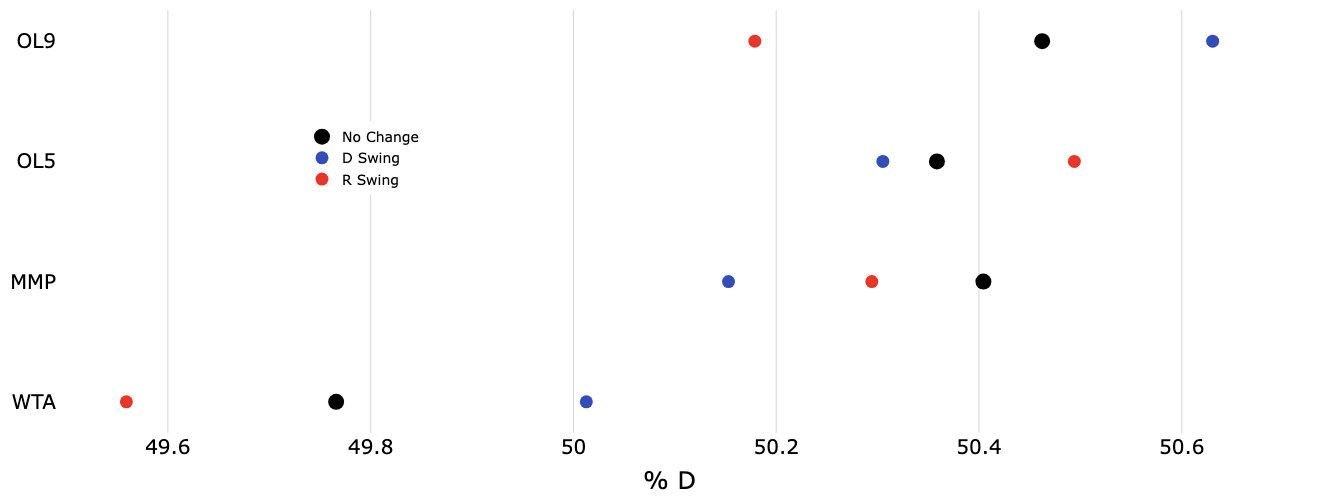

In [101]:
df_s1 = df_sm[df_sm['parties']==2]
df_s1["o"] = df_s1["type"].map({"MMP": 1, "OL5": 2, "OL9": 3, "WTA": 0})

t_ = ["WTA", "MMP", "OL5", "OL9"]
col = [
    pd_colors("vs purple", 0.7),
    pd_colors("vs orange", 0.7),
    pd_colors("vs green", 0.7),
    pd_colors("red", 0.7),
]
fig = go.Figure()
c = 0
for i, t in enumerate(t_):
    fig.add_trace(
        go.Scatter(
            x=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'no_change')]["d_mean"],
            y=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'no_change')]["o"],
            mode="markers",
            name='No Change',
            marker=dict(color='black', size=16),
            showlegend=(i == 0),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'more_dem')]["d_mean"],
            y=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'more_dem')]["o"],
            mode="markers",
            name="D Swing",
            marker=dict(color=pd_colors('blue'), size=13),
            showlegend=(i == 0),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'more_gop')]["d_mean"],
            y=df_s1[(df_s1["type"] == t) & (df_s1["scenario"] == 'more_gop')]["o"],
            mode="markers",
            name="R Swing",
            marker=dict(color=pd_colors('red'), size=13),
            showlegend=(i == 0),
        )
    )
    c = c + 1
fig.update_layout(
    #yaxis_title_text="Simulations (out of 1,000)",
    xaxis_title_text="% D",
    template="plotly_white",
    autosize=False,
    showlegend=True,
    legend=dict(x=0.2, y=0.65, font_size=14),
    font=dict(color="black", size=20),
    width=600,
    height=500,
    margin=dict(l=50, r=50, t=10, b=40),
    # xaxis_range=[-1.5, 1.5],
    xaxis_gridcolor=pd_colors("lead", 0.2),
    yaxis_gridcolor=pd_colors("lead", 0),
    # paper_bgcolor=pd_colors("cream", 0),
    # plot_bgcolor=pd_colors("cream", 0),
    yaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],
        ticktext=["WTA", "MMP", "OL5", "OL9"],
        zeroline=False,
    ),
)
fig.show()

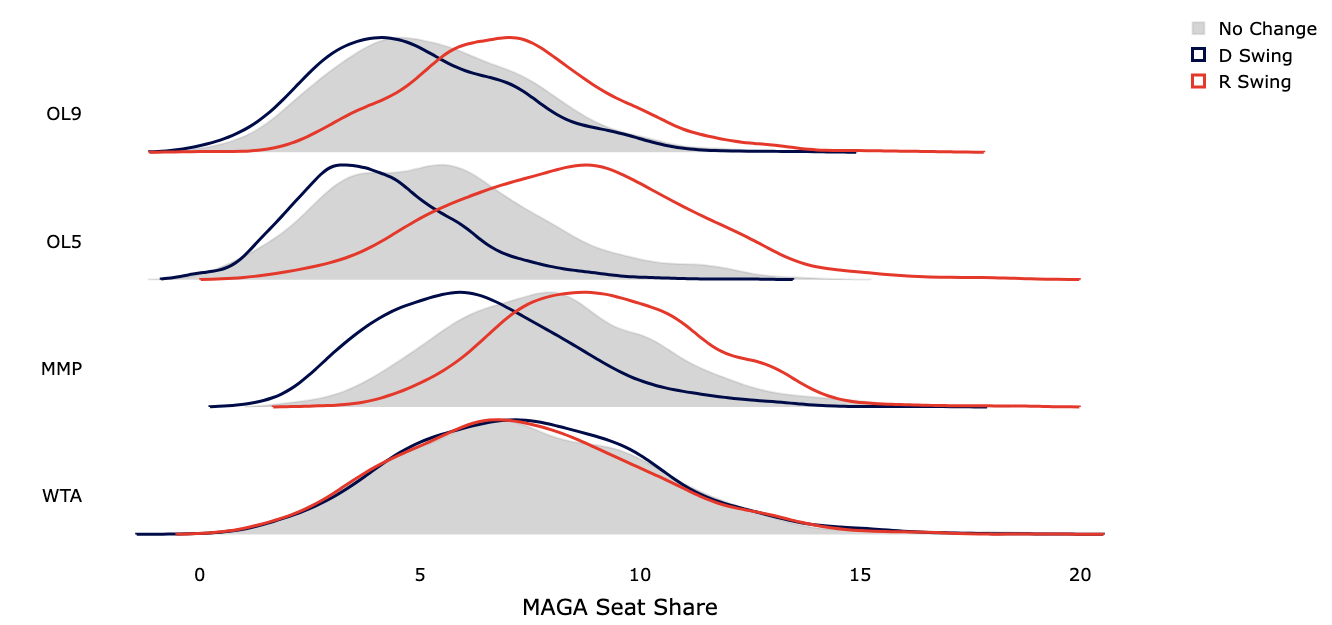

In [112]:
df_s2=df_swing[df_swing['parties']==4]
t_ = ["WTA", "MMP", "OL5", "OL9"]
c = "blue"
# Order
df_s2["o"] = df_s2["type"].map(
    {
        "WTA": 0,
        "MMP": 1,
        "OL5": 2,
        "OL9": 3,
    }
)


fig = go.Figure()
for i, t in enumerate(t_):
    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == "no_change") & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == "no_change") & (df_s2["type"] == t)]["m"],
            name="No Change",
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors('lead', 0.2),
            line_color=pd_colors('lead', .1),
            showlegend=(i == 0),
        )
    )

    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == "more_dem") & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == "more_dem") & (df_s2["type"] == t)]["m"],
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors("vs purple", 0),
            line_color=pd_colors("navy",),
            line_width=3,
            name='D Swing',
            showlegend=(i == 0),
        )
    )
    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == "more_gop") & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == "more_gop") & (df_s2["type"] == t)]["m"],
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors("vs purple", 0),
            line_color=pd_colors("red",),
            line_width=3,
            name='R Swing',
            showlegend=(i == 0),
        )
    )

fig.update_layout(
    yaxis_title_text="",
    xaxis_title_text="MAGA Seat Share",
    template="plotly_white",
    autosize=False,
    showlegend=True,
    font=dict(color="black", size=18),
    width=950,
    height=625,
    margin=dict(l=20, r=20, t=10, b=10),
    xaxis_zeroline=False,
    xaxis_gridcolor=pd_colors("lead", 0),
    yaxis=dict(
        tickmode="array",
        tickvals=[0.3, 1.3, 2.3, 3.3],
        ticktext=["WTA", "MMP", "OL5", "OL9"],
    ),
    # paper_bgcolor=pd_colors("cream", 0),
    # plot_bgcolor=pd_colors("cream", 0),
)
# fig.update_traces(meanline_visible=True, box_visible=False)
fig.update_traces(
    orientation="h",
    side="positive",
    width=1.8,
)
fig.show()

In [114]:
df_s2

,type,scenario,parties,D,R,P,M,p,d,r,m,o
0,MMP,no_change,4,54.0,57.0,13.0,14.0,9.420290,39.130435,41.304348,10.144928,1
1,MMP,no_change,4,54.0,57.0,13.0,14.0,9.420290,39.130435,41.304348,10.144928,1
2,MMP,no_change,4,54.0,57.0,15.0,12.0,10.869565,39.130435,41.304348,8.695652,1
3,MMP,no_change,4,53.0,56.0,10.0,19.0,7.246377,38.405797,40.579710,13.768116,1
4,MMP,no_change,4,55.0,56.0,17.0,10.0,12.318841,39.855072,40.579710,7.246377,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,WTA,more_gop,4,49.0,46.0,3.0,12.0,2.727273,44.545455,41.818182,10.909091,0
996,WTA,more_gop,4,48.0,49.0,5.0,8.0,4.545455,43.636364,44.545455,7.272727,0
997,WTA,more_gop,4,48.0,48.0,8.0,6.0,7.272727,43.636364,43.636364,5.454545,0
998,WTA,more_gop,4,39.0,55.0,4.0,12.0,3.636364,35.454545,50.000000,10.909091,0


In [117]:
df_s2
df_s2["o"] = df_s2["scenario"].map(
    {
        "more_dem": 0,
        "no_change": 1,
        "more_gop": 2,
    }
)


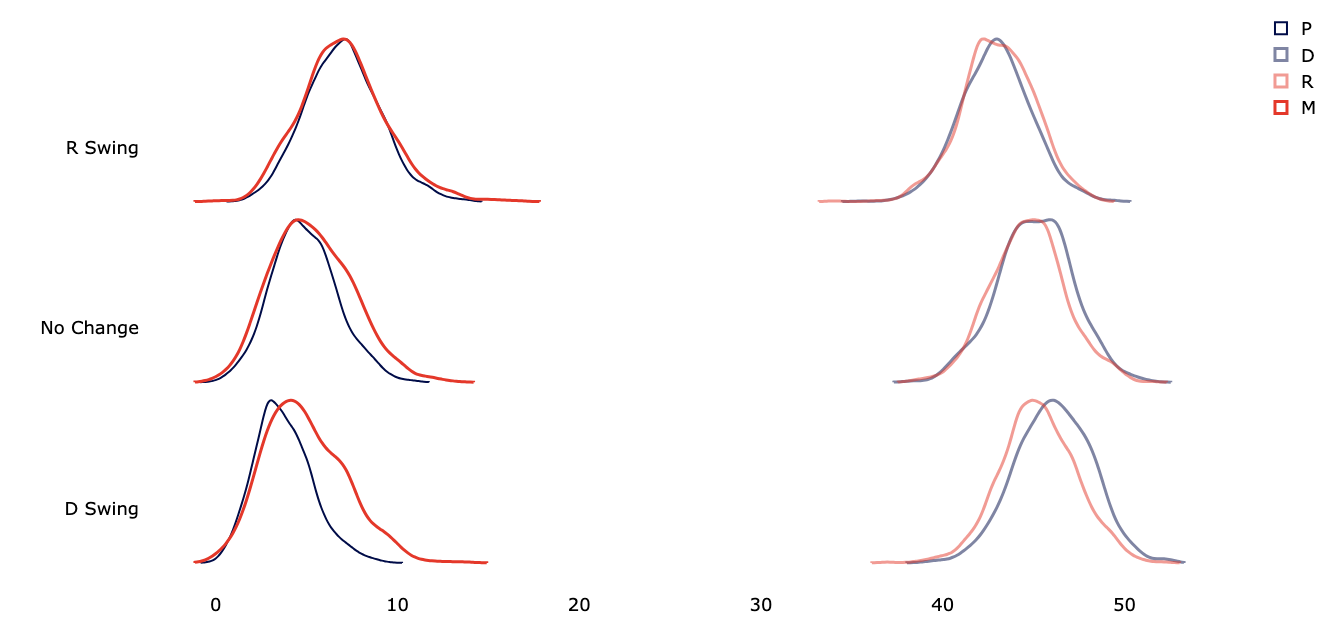

In [127]:
t='OL9'
fig = go.Figure()
for i, s in enumerate(['more_dem', 'no_change', 'more_gop']):
    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]['p'],
            name="P",
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors('lead', 0),
            line_color=pd_colors('navy', 1),
            showlegend=(i == 0),
        )
    )

    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]['d'],
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors("vs purple", 0),
            line_color=pd_colors("navy",.5),
            line_width=3,
            name='D',
            showlegend=(i == 0),
        )
    )
    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]['r'],
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors("vs purple", 0),
            line_color=pd_colors("red",.5),
            line_width=3,
            name='R',
            showlegend=(i == 0),
        )
    )
    fig.add_trace(
        go.Violin(
            y=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]["o"],
            x=df_s2[(df_s2["scenario"] == s) & (df_s2["type"] == t)]['m'],
            box_visible=False,
            meanline_visible=False,
            points=False,
            fillcolor=pd_colors("vs purple", 0),
            line_color=pd_colors("red",),
            line_width=3,
            name='M',
            showlegend=(i == 0),
        )
    )

fig.update_layout(
    yaxis_title_text="",
    #xaxis_title_text="MAGA Seat Share",
    template="plotly_white",
    autosize=False,
    showlegend=True,
    font=dict(color="black", size=18),
    width=950,
    height=625,
    margin=dict(l=20, r=20, t=10, b=10),
    xaxis_zeroline=False,
    xaxis_gridcolor=pd_colors("lead", 0),
    yaxis=dict(
        tickmode="array",
        tickvals=[0.3, 1.3, 2.3],
        ticktext=["D Swing", "No Change", "R Swing"],
    ),
    # paper_bgcolor=pd_colors("cream", 0),
    # plot_bgcolor=pd_colors("cream", 0),
)
# fig.update_traces(meanline_visible=True, box_visible=False)
fig.update_traces(
    orientation="h",
    side="positive",
    width=1.8,
)
fig.show()

In [125]:
df_s2[(df_s2["scenario"] == 'no_change') & (df_s2["type"] == t)]['r']

0      45.652174
1      44.202899
2      49.275362
3      44.927536
4      42.028986
         ...    
995    42.028986
996    44.202899
997    42.753623
998    43.478261
999    42.028986
Name: r, Length: 1000, dtype: float64